Devnagiri character recognition

Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00389/

Blog: https://medium.com/@sairahul/image-classification-with-fastai-763358f5c80

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import shutil

from fastai import *
from fastai.vision import *

In [2]:
path = './DevanagariHandwrittenCharacterDataset/'

Loading datasets

In [3]:
#xtra_tfms = [skew(direction=(0, 1), magnitude=(-0.5, 0.5))]
# You could create additional transformations and pass them to get_transformations
tfms = get_transforms(do_flip=False, xtra_tfms=None)
data = ImageDataBunch.from_folder(f'{path}', train='Train', valid='Test', ds_tfms=tfms, size=32)

Above step (Data Agumentation) is very important. We have to think about the transformations that are valid for our problem. 

Not all the transformations are applicable for every problem. For example, if you are training a self driving car, flipping the images and using them for traning does not make sense. For self driving car training, Nvidia (https://devblogs.nvidia.com/deep-learning-self-driving-cars/) used shifted and rotated version of the image to simulate the bad driving angles. In medical datasets we add Gaussian noise some times and while training voice samples we add white noise. 

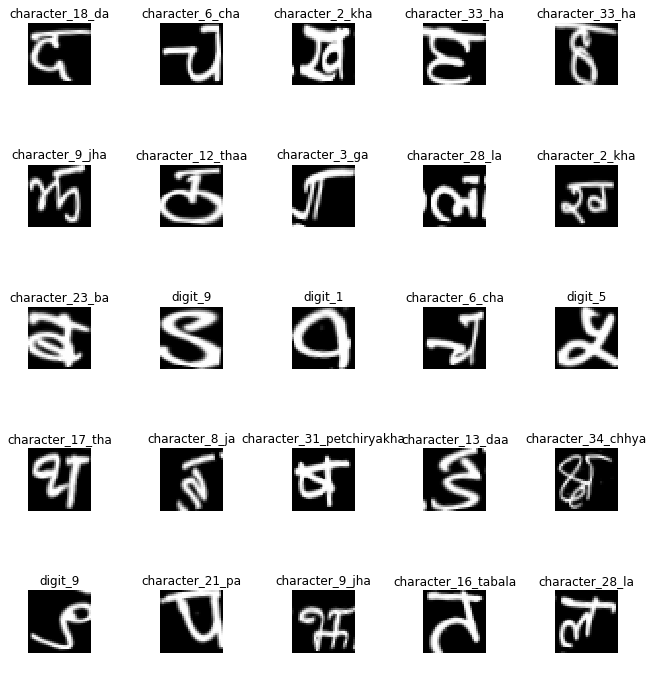

In [4]:
#Visualize the dataset
data.show_batch(rows=5)

We are using resnet34 pretrained model. create_cnn will take all the layers of resnet34 except the last one. It adds the additional layer with the number of neurons equal to our classes. It gets that information from "data" which we created in the above step. 

Here we are not training all the layers. We are training only the last layer and rest of the layers are frozen. 

In [5]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(2)

Total time: 03:31
epoch  train_loss  valid_loss  accuracy
1      0.695331    0.383618    0.877391  (02:44)
2      0.433380    0.209116    0.933333  (00:46)



Learning rate is the an important parameter that determines our training quality and training time. By finding out how it is varying we can optimize the model for speed and accuracy. 

The first step is to see how it is varying w.r.t loss.

In [6]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


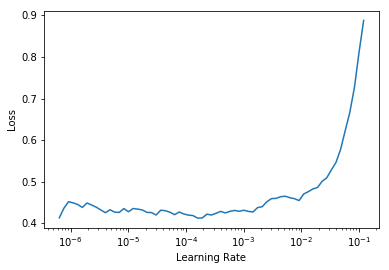

In [8]:
learn.recorder.plot()

We use a technique called cyclic learning rate. We vary our learning rate between two values. These values are determined based on the above plot. We may not want to choose the learning rate where the loss is increasing or diverging. At the same time we also want a higher learning rate but not too high. 1e-6 to 1e-4 is such a range. It is not too high and provides a good range for LR to explore the space

In [7]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

Total time: 03:05
epoch  train_loss  valid_loss  accuracy
1      0.398497    0.198510    0.937899  (00:45)
2      0.408679    0.195195    0.938043  (00:46)
3      0.402929    0.189019    0.941159  (00:46)
4      0.377265    0.187905    0.940725  (00:47)



In [8]:
learn.save('devnagiri-v1')

We got pretty good accuracy here. We can fine tune our model further by training all the layers instead of the last one alone. Lets unfreeze all the layers and repeat the above process. 

In [9]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


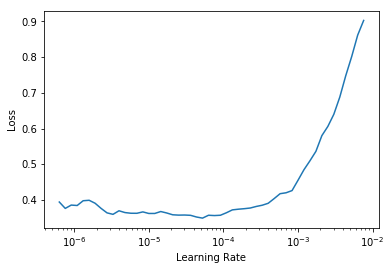

In [10]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, max_lr=slice(5e-6, 5e-5))

Total time: 03:49
epoch  train_loss  valid_loss  accuracy
1      0.121499    0.059899    0.982464  (00:56)
2      0.106818    0.050526    0.984420  (00:58)
3      0.094783    0.042302    0.986739  (00:56)
4      0.087974    0.038954    0.987609  (00:57)



In [13]:
learn.save('devnagiri-v2')

We got 98.7% accuracy. Lets see where our model is doing mistakes. 

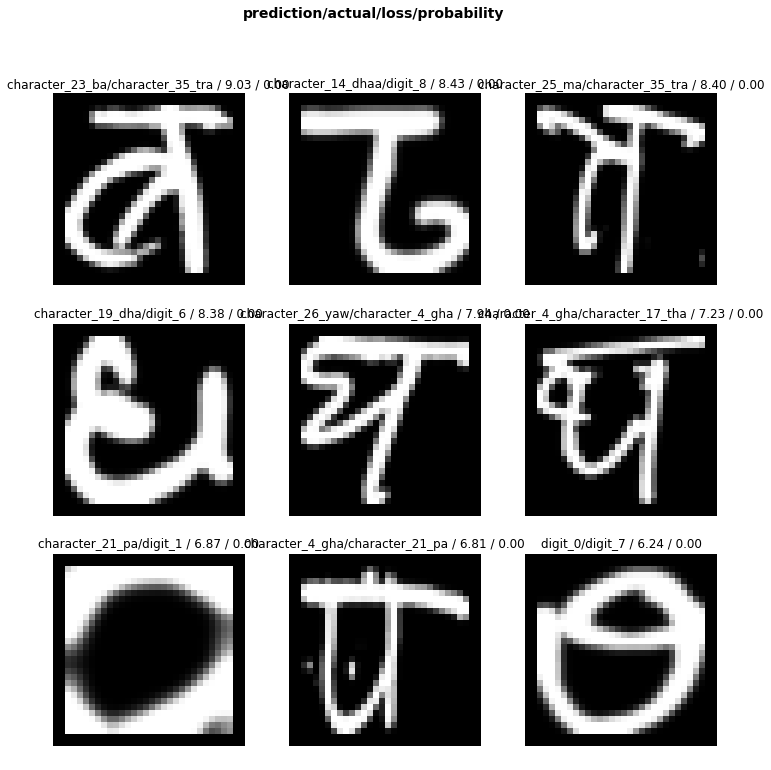

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

In [15]:
interp.most_confused(min_val=2)[:10]

[('character_18_da', 'character_14_dhaa', 8),
 ('character_23_ba', 'character_29_waw', 6),
 ('character_26_yaw', 'character_17_tha', 6),
 ('character_19_dha', 'character_4_gha', 5),
 ('character_19_dha', 'character_17_tha', 4),
 ('character_24_bha', 'character_25_ma', 4),
 ('character_5_kna', 'character_13_daa', 4),
 ('character_12_thaa', 'character_14_dhaa', 3),
 ('character_17_tha', 'character_19_dha', 3),
 ('character_17_tha', 'character_4_gha', 3)]

We can further increase the accuracy using a technique called Test time Augmentation (TTA). In TTA, instead of passing just the test image to our model, we take different augmented versions (rotate, scaled, flip etc) and pass all of them. The class that is repeating most is our predicted class.

In [16]:
preds, y = learn.TTA()
print("Accuracy with TTA (Test Time Augumentation)")
print(accuracy(preds, y))

Total time: 00:20

Accuracy with TTA (Test Time Augumentation)
tensor(0.9884)


## With resnet18

Lets repeat the above process with a different base model. We used resnet18 here. This is a bit simpler model than resnet34. We have total 18 layers instead of 34. 

In [17]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(2)

Total time: 00:57
epoch  train_loss  valid_loss  accuracy
1      0.960716    0.560201    0.828696  (00:28)
2      0.612024    0.342140    0.896087  (00:28)



LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


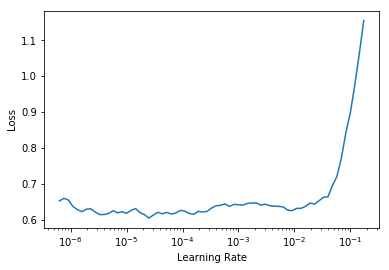

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.save('devnagiri-resnet18-v1')

In [20]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

Total time: 02:49
epoch  train_loss  valid_loss  accuracy
1      0.554577    0.326271    0.903478  (00:28)
2      0.591621    0.318311    0.905217  (00:28)
3      0.563793    0.315577    0.906667  (00:28)
4      0.574216    0.309544    0.906957  (00:28)
5      0.579285    0.308708    0.907029  (00:28)
6      0.558533    0.303884    0.908841  (00:29)



In [21]:
learn.save('devnagiri-resnet18-v2')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


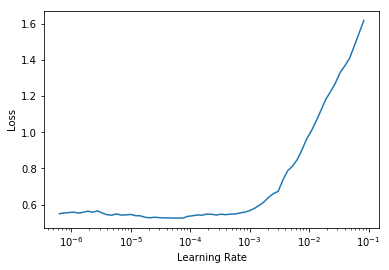

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(6, max_lr=slice(5e-6, 5e-4))

Total time: 03:33
epoch  train_loss  valid_loss  accuracy
1      0.380004    0.180639    0.945435  (00:35)
2      0.231686    0.100642    0.969710  (00:35)
3      0.149147    0.067796    0.978696  (00:35)
4      0.119001    0.051909    0.983913  (00:35)
5      0.101454    0.041693    0.987246  (00:35)
6      0.077075    0.041330    0.987029  (00:35)



In [24]:
learn.save('devnagiri-resnet18-v3')

In [25]:
preds, y = learn.TTA()
print("Accuracy with TTA (Test Time Augumentation)")
print(accuracy(preds, y))

Total time: 00:20

Accuracy with TTA (Test Time Augumentation)
tensor(0.9880)


In [27]:
learn

ClassificationLearner(data=<fastai.vision.data.ImageDataBunch object at 0x7fc52d8b4908>, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [51]:
#from torchsummary import summary
#summary(models.resnet18, input_size=(32, 32))
mm = models.resnet18()
print(mm)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [41]:
data.train_ds[0][0].size

torch.Size([32, 32])

Visualizing the convolutional filters: https://github.com/sairahul/notebooks/blob/master/devnagiri_experiments.ipynb